# **Linking Writing Processes to Writing Quality**
### Use typing behavior to predict essay quality

This notebook is modified from the following notebooks:  
[EDA for better data understanding](https://www.kaggle.com/code/datark1/eda-for-better-data-understanding)  
[Feature Engineering: Sentence & paragraph features](https://www.kaggle.com/code/hiarsl/feature-engineering-sentence-paragraph-features)  
[📒 Writing Processes to Quality - Baseline](https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline)  
[Silver Bullet | Single Model | 165 Features](https://www.kaggle.com/code/awqatak/silver-bullet-single-model-165-features)  

## Import Libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

from lightgbm import LGBMRegressor

## Read in data

In [2]:
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

test_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')

DATA_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


## Data dictionary

Let's dicover the data which are composed of :
- events
- activities
- scores

**Events**

| Column             | Definition                                                                |
| ------------------ | ------------------------------------------------------------------------- |
| essay_id_comp      | The unique ID of the essay                                                |
| event_id           | The index of the event, ordered chronologically                           |
| down_time          | The time of the down event in milliseconds                                |
| up_time            | The time of the up event in milliseconds                                  |
| action_time        | The duration of the event (the difference between down_time and up_time)  |
| activity           | The category of activity which the event belongs to                       |
| down_event         | The name of the event when the key/mouse is pressed                       |
| up_event           | The name of the event when the key/mouse is released                      |
| text_change        | The text that changed as a result of the event (if any)                   |
| cursor_position    | The character index of the text cursor after the event                    |
| word_count         | The word count of the essay after the event                               |

**Activities**

| Activity Name                  | Definition                                                                                 |
| ------------------------------ | ------------------------------------------------------------------------------------------ |
| Nonproduction                  | The event does not alter the text in any way                                               |
| Input                          | The event adds text to the essay                                                           |
| Remove/Cut                     | The event removes text from the essay                                                      |
| Paste                          | The event changes the text through a paste input                                           |
| Replace                        | The event replaces a section of text with another string                                   |
| Move From [x1, y1] To [x2, y2] | The event moves a section of text spanning character index x1, y1 to a new location x2, y2 |

**Scores**

| Column         | Definition                                                                        |
| -------------- | --------------------------------------------------------------------------------- |
| essay_id_comp  | The unique ID of the essay                                                        |
| score          | The score the essay received out of 6 (the prediction target for the competition) |
| split          | The train-test split of the essay                                                 |

## Data Exploration

In [3]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


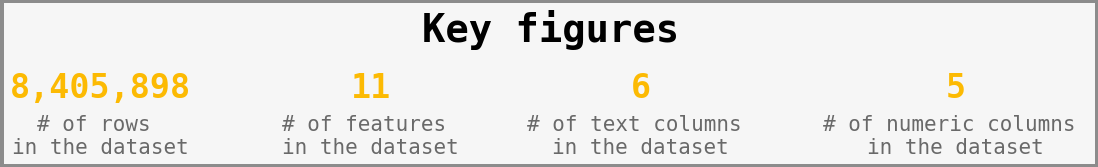

In [4]:
mpl.rcParams.update(mpl.rcParamsDefault)

data = train_logs.copy()
art_dtypes = data.dtypes.value_counts()

fig = plt.figure(figsize=(5,2),facecolor='white')
ax0 = fig.add_subplot(1,1,1)
ax0.text(1, 0.8, "Key figures",color='black',fontsize=28, fontweight='bold', fontfamily='monospace', ha='center')

ax0.text(0, 0.4, "{:,d}".format(data.shape[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(0, 0.001, "# of rows \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(0.6, 0.4, "{}".format(data.shape[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(0.6, 0.001, "# of features \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(1.2, 0.4, "{}".format(art_dtypes[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(1.2, 0.001, "# of text columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(1.9, 0.4,"{}".format(art_dtypes[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(1.9, 0.001,"# of numeric columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.tick_params(axis='y',length=0)
ax0.tick_params(axis='x',length=0)
ax0.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax0.spines[direction].set_visible(False)

fig.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#8c8c8c')
fig.patch.set_facecolor('#f6f6f6')
ax0.set_facecolor('#f6f6f6')
    
plt.show()

In [5]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


## Target variable: "Score"

In [6]:
print(f"Minimum score is: {train_scores['score'].min()}")
print(f"Maximum score is: {train_scores['score'].max()}")

Minimum score is: 0.5
Maximum score is: 6.0


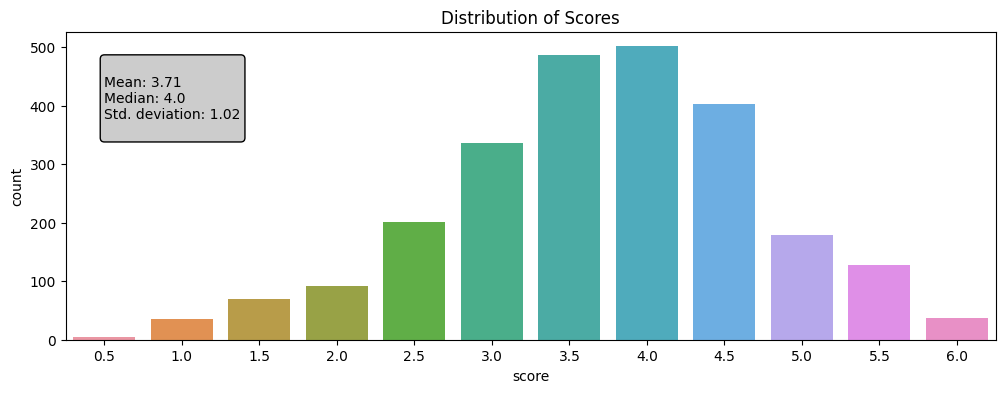

In [7]:
# Display the distribution of scores
text = f"""
Mean: {train_scores['score']
.mean().round(2)}
Median: {train_scores['score'].median().round(2)}
Std. deviation: {train_scores['score'].std().round(2)}
"""
bbox = dict(boxstyle = "round", fc = "0.8")

f, ax = plt.subplots(figsize = (12, 4))
ax = sns.countplot(
    data = train_scores,
    x = "score"
)
ax.set_title("Distribution of Scores")
ax.annotate(text, (0, 350), bbox = bbox)
plt.show()

## Variables "id" and "event"

In [8]:
print(f'Number of unique essays in train: {train_logs["id"].nunique()}')
print(f'Number of unique essays in test:  {test_logs["id"].nunique()}')

Number of unique essays in train: 2471
Number of unique essays in test:  3


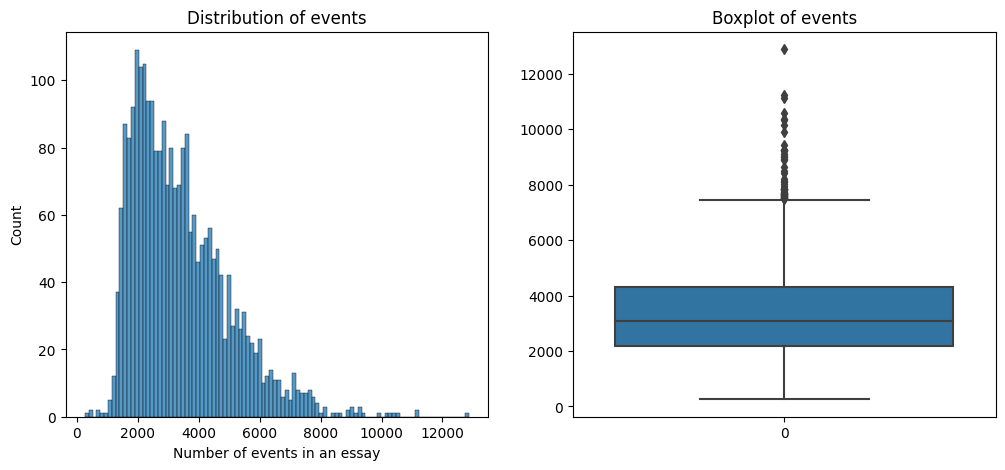

In [9]:
# Display the distribution of events by essay
event_stats = train_logs.groupby("id")['event_id'].max()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of events')
ax[0].set_xlabel('Number of events in an essay')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

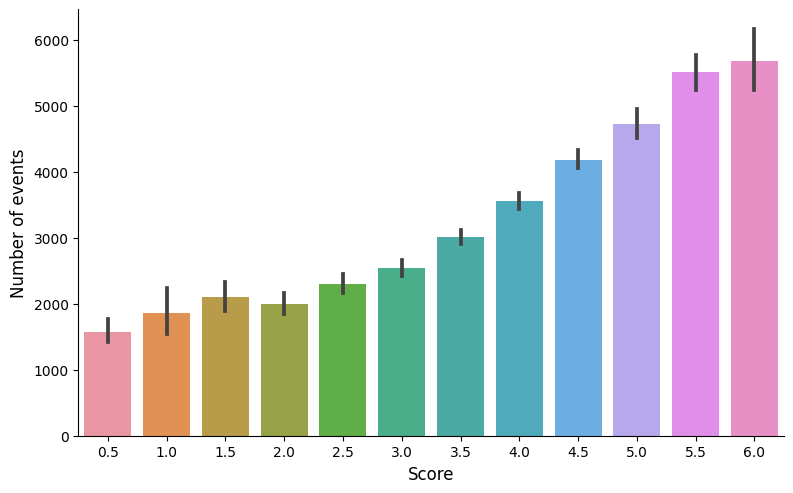

In [10]:
# Check for correlation between the number of events and the score
stats_score = train_logs.groupby("id")["event_id"].max().reset_index().merge(train_scores, on = "id")

catplot = sns.catplot(
    data = stats_score,
    x = "score",
    y = "event_id",
    kind = "bar",
    height = 5,
    aspect = 8/5
)
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Number of events", fontsize = 12)
plt.show()

From this plot, there is evidence of positive correlation between the number of events in an essay and the final score

## Variables "down_time", "up_time", and "action_time"

`down_time` - The time of the down event in milliseconds  
`up_time` - The time of the up event in milliseconds  
`action_time` - The duration of the event (the difference between down_time and up_time)  

In [11]:
# Check to make sure action_time = up_time - down_time
tmp = train_logs["up_time"] - train_logs["down_time"]
results = (tmp == train_logs["action_time"])
results.value_counts()

True    8405898
Name: count, dtype: int64

action_time is indeed calculated correctly for each row, so that variable can be trusted

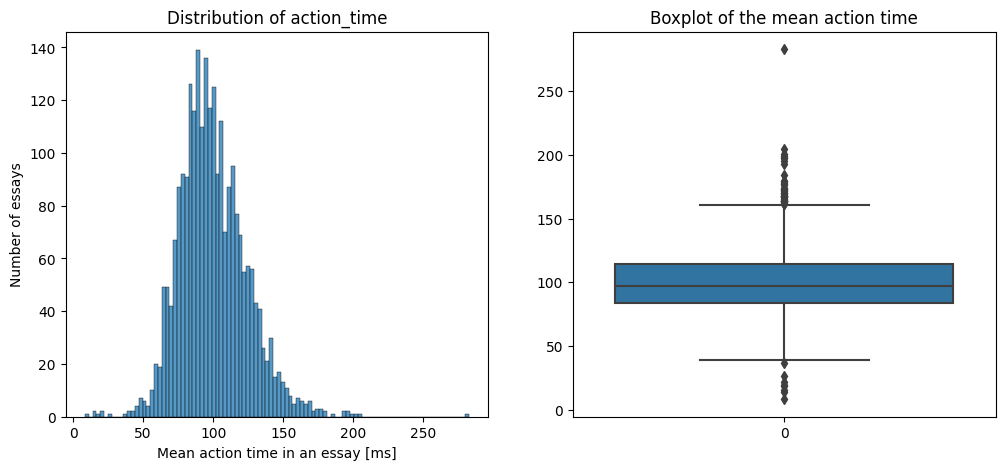

In [12]:
# Display the distribution of action_time
stats = train_logs.groupby("id")["action_time"].mean()

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].set_title("Distribution of action_time")
ax[0].set_xlabel("Mean action time in an essay [ms]")
ax[0].set_ylabel("Number of essays")
sns.histplot(
        stats,
        bins = 100,
        ax = ax[0]
        )
ax[1].set_title("Boxplot of the mean action time")
sns.boxplot(
        stats,
        ax = ax[1]
        )
plt.show()

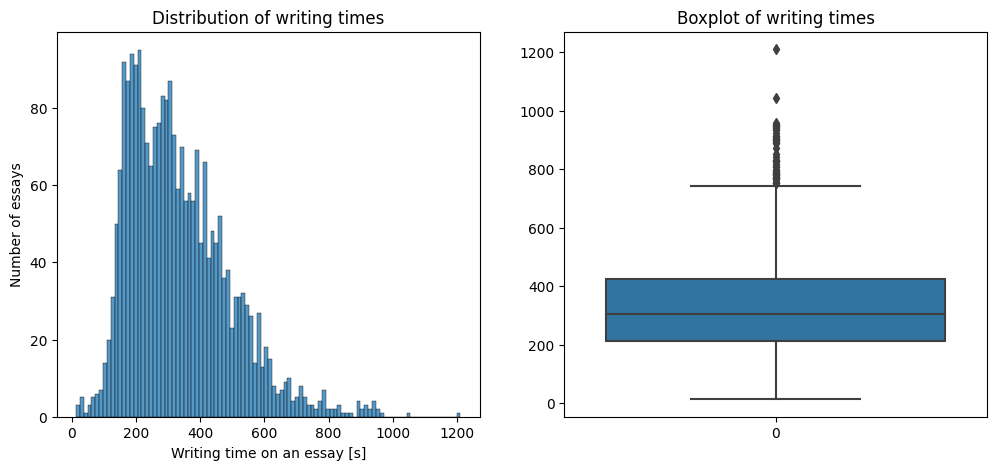

In [13]:
# Display the distribution of total writing time
stats = train_logs.groupby("id")["action_time"].sum().div(1000)

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].set_title('Distribution of writing times')
ax[0].set_xlabel('Writing time on an essay [s]')
ax[0].set_ylabel('Number of essays')
sns.histplot(stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of writing times')
sns.boxplot(stats, ax=ax[1])
plt.show()


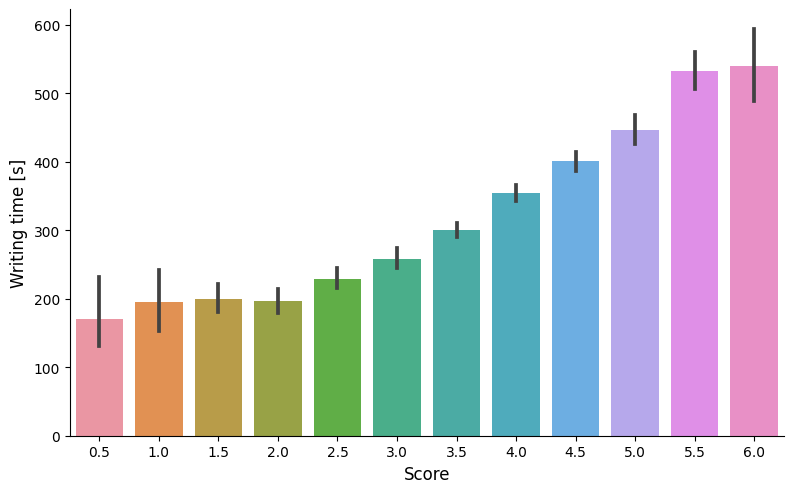

In [14]:
# Check for correlation between writing time and essay score
stats_score = train_logs.groupby("id")["action_time"].sum().div(1000).reset_index().merge(train_scores, on = "id")

catplot = sns.catplot(
        data = stats_score,
        x = "score",
        y = "action_time",
        kind = "bar",
        height = 5,
        aspect = 8/5
        )
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Writing time [s]", fontsize = 12)
plt.show()

From this plot, there is evidence of positive correlation between the total writing time and the essay score

### Variable "activity"

`activity` is the category of activity which the event belongs to. There are 6 types of activities:

1. `Nonproduction` - The event does not alter the text in any way
2. `Input` - The event adds text to the essay
3. `Remove/Cut` - The event removes text from the essay
4. `Paste` - The event changes the text through a paste input
5. `Replace` - The event replaces a section of text with another string
6. `Move From [x1, y1] To [x2, y2]` - The event moves a section of text spanning character index x1, y1 to a new location x2, y2

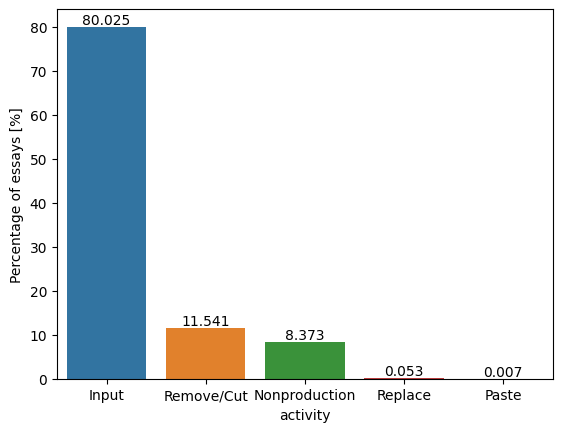

In [15]:
vals_of_interest = [
        "Nonproduction",
        "Input",
        "Remove/Cut",
        "Paste",
        "Replace"
        ]
sub_df = train_logs[train_logs["activity"].isin(vals_of_interest)]["activity"]

tmp_stats = sub_df.value_counts()\
        .div(len(sub_df))\
        .mul(100)\
        .round(3)\
        .reset_index()

ax = sns.barplot(
        tmp_stats,
        x = "activity",
        y = "count",
        errorbar = None
        )

ax.bar_label(ax.containers[0], fontsize = 10)
ax.set_ylabel("Percentage of essays [%]")
plt.show()

### Variables "down_event" and "up_event"

In [16]:
# List the most common events
train_logs["down_event"].value_counts()[:20]

down_event
q               5365319
Space           1207128
Backspace        964089
Shift            334227
ArrowRight       121338
Leftclick         91126
ArrowLeft         63217
.                 59586
,                 46806
ArrowDown         30874
ArrowUp           28189
Enter             22689
CapsLock          12568
'                 11170
Delete            10965
Unidentified       6151
Control            4885
"                  4102
-                  3843
?                  3155
Name: count, dtype: int64

The most common down event is "q", which in this case represents any alphanumeric character. 

In [17]:
print(f'Number of unique down events: {train_logs["down_event"].nunique()}')
print(f'Number of unique up events: {train_logs["up_event"].nunique()}')

Number of unique down events: 131
Number of unique up events: 130


In [18]:
# Investigate which up events are not present in the set of down events
set(train_logs["up_event"].unique()).difference(set(train_logs["down_event"].unique()))

{'k'}

In [19]:
# Investigate which down events are not present in the set of up events
set(train_logs["down_event"].unique()).difference(set(train_logs["up_event"].unique()))

{'F', 'I'}

In [20]:
# Investigate the fastest and slowest events
event_stats = train_logs[["down_event", "up_event", "action_time"]]\
        .groupby("down_event")["action_time"]\
        .mean()\
        .sort_values()

# Fastest events
event_stats[:10]

down_event
j          0.0
l          0.0
F1         0.0
Pause      0.0
Control    0.0
Shift      0.0
T          0.0
Alt        0.0
F6         0.0
f          0.2
Name: action_time, dtype: float64

In [21]:
# Slowest events
event_stats[-10:]

down_event
CapsLock        189.622215
Å              221.000000
C               222.000000
Leftclick       263.812425
Rightclick      320.974046
Meta            675.605428
ModeChange     1882.864865
F3             2212.555556
n              6237.750000
Process       35134.538462
Name: action_time, dtype: float64

The slowest events by far are: "Process", "n", "F3", and "ModeChange". It would be useful to know what these events mean. However, as we can see from the distribution of events, these are very rare events.

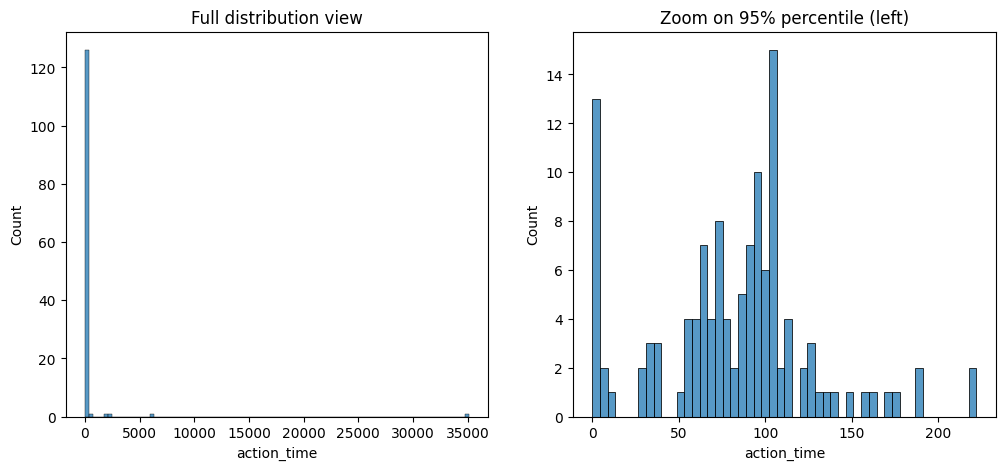

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Full distribution view')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Zoom on 95% percentile (left)')
event_stats_95 = event_stats[event_stats<event_stats.quantile(0.95)]
sns.histplot(event_stats_95, bins=50, ax=ax[1])
plt.show()

### Variable "word_count"

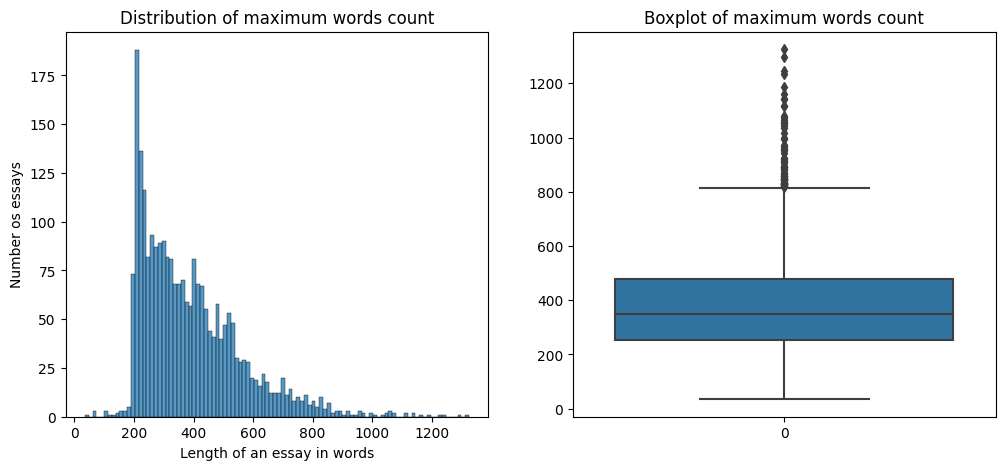

In [23]:
# Display the distribution of word counts
event_stats = train_logs.groupby("id")['word_count'].max()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of maximum words count')
ax[0].set_xlabel('Length of an essay in words')
ax[0].set_ylabel('Number os essays')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of maximum words count')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

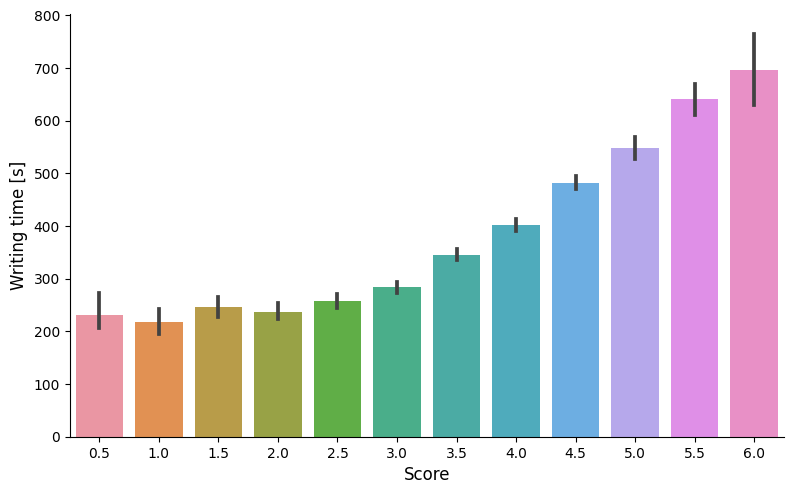

In [24]:
# Check for correlation between word count and score
stats_score = train_logs.groupby("id")["word_count"]\
        .max()\
        .reset_index()\
        .merge(train_scores, on = "id")

catplot = sns.catplot(
        data = stats_score,
        x = "score",
        y = "word_count",
        kind = "bar",
        height = 5,
        aspect = 8/5
        )
plt.xlabel('Score', fontsize=12)
plt.ylabel('Writing time [s]', fontsize=12)
plt.show()

From this plot, there is evidence of correlation between total writing time and essay score